In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
working_dir = os.path.expanduser('~/workspace/theislab/mubind/docs/notebooks/scatac')
if os.path.exists(working_dir):
    os.chdir(working_dir)
from IPython.core import ultratb; ultratb.VerboseTB._tb_highlight = "bg:ansired"


In [3]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
# mb.models.Mubind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [4]:
h5ad_path = '../../../../scchipseq_drosophila/s03_glue/ctcf.h5ad'

In [78]:
import scanpy as sc
adata = sc.read_h5ad(h5ad_path)

In [79]:
sc.pp.neighbors(adata, use_rep='X_glue')
sc.tl.umap(adata)

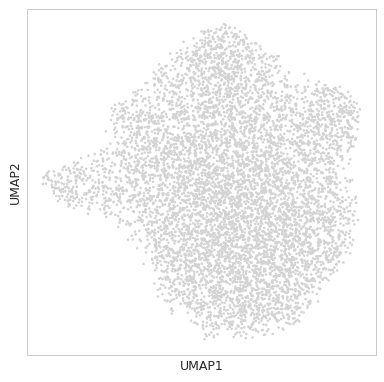

In [80]:
sc.pl.umap(adata)

In [81]:
n_sample_cells = 100 # adata.shape[0]
n_sample_peaks = 250 # adata.shape[1]

In [82]:
np.random.seed(100)

# adata = adata[:,adata.var.modality == 'CTCF'].copy()
obs_sample = pd.Series(adata.obs_names).sample(n_sample_cells)
var_sample = pd.Series(adata.var_names).sample(n_sample_peaks)

adata = adata[adata.obs_names.isin(obs_sample),adata.var_names.isin(var_sample)]

In [83]:
adata.shape

(500, 1000)

In [84]:
adata

View of AnnData object with n_obs × n_vars = 500 × 1000
    obs: 'seurat_clusters', 'modality', 'balancing_weight', 'annotation', 'cell_type'
    var: 'chrom', 'chromStart', 'chromEnd', 'strand', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'modality'
    uns: '__scglue__', 'annotation_colors', 'hvg', 'neighbors', 'umap'
    obsm: 'X_cistopic_umap', 'X_cistopic_zscores', 'X_counts', 'X_glue', 'X_glue_umap', 'X_lsi', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

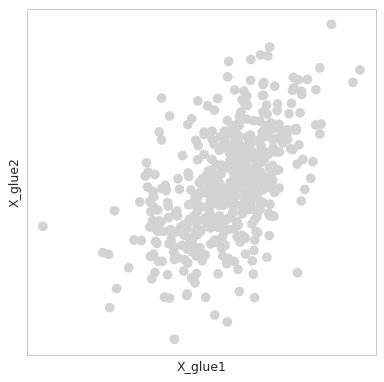

In [85]:
sc.pl.embedding(adata, basis='X_glue')

In [86]:
adata.shape

(500, 1000)

In [87]:
adata.var['chr'] = adata.var['chrom']
adata.var['start'] = adata.var['chromStart'].astype(int)
adata.var['end'] = adata.var['chromEnd'].astype(int)

In [88]:
adata.var

,chrom,chromStart,chromEnd,strand,highly_variable,means,dispersions,dispersions_norm,modality,chr,start,end
annot,,,,,,,,,,,,
chr2L:10056492-10057770,chr2L,10056492.0,10057770.0,+,False,0.095213,2.226756,0.352756,CTCF,chr2L,10056492,10057770
chr2L:10269748-10270263,chr2L,10269748.0,10270263.0,+,False,0.017000,1.234790,-0.481584,CTCF,chr2L,10269748,10270263
chr2L:10314163-10314867,chr2L,10314163.0,10314867.0,-,False,0.021152,1.061537,-0.627308,CTCF,chr2L,10314163,10314867
chr2L:10339408-10339710,chr2L,10339408.0,10339710.0,-,False,0.015382,1.208719,-0.503513,CTCF,chr2L,10339408,10339710
chr2L:10426367-10427166,chr2L,10426367.0,10427166.0,+,False,0.036808,1.317720,-0.411833,CTCF,chr2L,10426367,10427166
...,...,...,...,...,...,...,...,...,...,...,...,...
chrX:9736910-9737336,chrX,9736910.0,9737336.0,-,False,0.016963,0.991686,-0.686059,CTCF,chrX,9736910,9737336
chrX:9890701-9891447,chrX,9890701.0,9891447.0,-,False,0.048164,1.792815,-0.012231,CTCF,chrX,9890701,9891447
chrY:1417480-1417939,chrY,1417480.0,1417939.0,-,False,0.015852,1.696946,-0.092866,CTCF,chrY,1417480,1417939


In [89]:
extend = 50

adata.var['chr'].value_counts()

chr3R    225
chr2R    206
chr2L    202
chr3L    202
chrX     148
chr4      14
chrY       3
Name: chr, dtype: int64

In [90]:
adata.var['summit'] = ((adata.var['end'] + adata.var['start']) / 2).astype(int)
adata.var['summit.start'] = adata.var['summit'] - extend
adata.var['summit.end'] = adata.var['summit'] + extend

In [91]:
adata.var['k.summit'] = adata.var['chr'].astype(str) + ':' + adata.var['summit.start'].astype(str) + '-' + adata.var['summit.end'].astype(str)

In [92]:
adata.shape

(500, 1000)

In [93]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(adata.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='../../../annotations/dm6/genome/dm6.fa')
keys = set([s[0] for s in seqs])
adata = adata[:,adata.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]

convert bed to fasta
/tmp/tmp3wj2kna0
genome mm10 True
../../../annotations/dm6/genome/dm6.fa
True ../../../annotations/dm6/genome/dm6.fa
running bedtools...
bedtools getfasta -fi ../../../annotations/dm6/genome/dm6.fa -bed /tmp/tmp3wj2kna0 -fo /tmp/tmpaa_y7__t
get fasta
/tmp/tmpaa_y7__t


In [94]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = adata.X.T

In [95]:
next_data = pd.DataFrame(counts) # sparse.from_spmatrix(counts.A)
# next_data = pd.DataFrame.sparse.from_spmatrix(counts)# var = []
# for ri, r in next_data.iterrows():
#     if ri % 1000 == 0:
#         print(ri, next_data.shape)
#     # print(ri, r.values[:-1], r.values[:-1].var())
#     var.append(r.values[:-1].var())
#     # break


next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

next_data.index = [str(i) + '-' + s[1] for i, s in enumerate(seqs)]
next_data.index.name = 'seq'
print(next_data.shape)

n_cells = adata.shape[0]
n_peaks = adata.shape[1]
print('# cells', n_cells)
print('# peaks', n_peaks)
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_peaks]

# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

next_data_sel

del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0

df = df[~zero_counts] # remove zeroes

df.shape

(1000, 501)
# cells 500
# peaks 1000


(986, 500)

In [96]:
df.index = [v.split('-')[1] for v in df.index]
df.index.name = 'seq'

In [97]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [98]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(493000, 3)
500
0      986
137    986
127    986
128    986
129    986
      ... 
69     986
70     986
71     986
72     986
199    986
Name: batch, Length: 200, dtype: int64


,0,1,batch
seq,,,
AAATGGGTGGTTTCATTAATTAACAAATGTTTGGAAAGTACTTTACTCACCTTAAAGGAACATTCACTGGATTTCTCCAACACCGTGGCAGCGCCCTCTA,1.0,0.0,0
GCACTATCGATTACATTGATGCCACTGCGATATTTCGTATTTTTGCGCTTCACAACACTGAATTTTCGTTTGCTAAGGCGCCACCTATCTGCTTAATGTT,1.0,0.0,0
TCCTAAAAATAGGCATCATTTATTTTACTTCACAAGGACTCGCTCATGCCTAAAAGTATGCAGAAATTTGTTCAACAAGTCTGCTTATGTGCACCCTCTC,1.0,0.0,0
CATACATTACAAATAAGCACATAACTATTACTGTGCTGCCATCTACCGGCAATGCGACTTTCATTTACAGACGCTAGATGTCGCCCAAACAGTTCGTCGA,1.0,0.0,0
TGGCGCTCGTACTTAAACTTTTCTTAATTCTATAGCTGTTGCTAAACTATTTGCCAAAAAAAAAAAACATTGAAATATCAACAAACATGTATAAATTATT,1.0,0.0,0


### This is the relatedness graph and used for dynamics filters learning

In [99]:
# sum(adata.obs_names.isin(df.index)

In [100]:
len(seqs)

1000

In [101]:
zero_counts.shape, adata.shape

((1000,), (500, 1000))

In [102]:
adata.shape

(500, 1000)

In [103]:
# adata = adata.T

In [ ]:
sc.pp.neighbors(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [ ]:
#  conn_sparse = adata[:,~zero_counts].uns['neighbors']['connectivities']
conn_sparse = adata.uns['neighbors']['connectivities']
conn_sparse

In [ ]:
# adata = adata.T

In [ ]:
rel = conn_sparse.A
# rel[:n_cells,:n_cells].sum()
rel.shape

In [ ]:
adata.shape

In [ ]:
# df2 = []
# for i in df.columns:
#     df3 = df[[i]].copy()
#     df3 = df3.head(100)
#     df3.columns = [0]
#     df3[1] = 1 # need a minimal non-zero count
#     df3['batch'] = i
#     df2.append(df3)
# df2 = pd.concat(df2)
# # df2['is_count_data'] = True
# dataset = mb.datasets.SelexDataset(df2, n_rounds=2, labels=[0, 1], enr_series=False)
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
len(set(dataset.batch))

In [ ]:
n_batch = len(set(dataset.batch))
n_batch

In [ ]:
# df = next_data_sel.copy()
# dataset = mb.datasets.GenomicsDataset(df)
# train = tdata.DataLoader(dataset=dataset, batch_size=1000, shuffle=True)

train = tdata.DataLoader(dataset=dataset, batch_size=1024, shuffle=True)


In [ ]:
# log_etas = torch.tensor(np.log(df.sum(axis=0) / df.sum().sum())).reshape(1, n_batch).to(device)
# log_etas

In [ ]:
b = np.random.randint(0, 2, (3, 4))
conn = np.random.randint(0, 2, (4, 4))

In [ ]:
n_kernels = 5

In [ ]:
import torch.optim as topti
import warnings
warnings.filterwarnings("ignore")

criterion = mb.tl.PoissonLoss()

w = [20 for i in range(n_kernels - 2)]
model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2] + w,
                                       # use_dinuc=True, dinuc_mode='full',
                                       optimize_sym_weight=False,
                                       optimize_exp_barrier=True,
                                       optimize_log_dynamic=True,
                                       use_dinuc=False,
                                       device=device,
                                       dinuc_mode=None,
                                       adata=adata,
                                       prepare_knn=True)# .cuda()



In [ ]:
# %load_ext line_profiler

In [ ]:
# %lprun -f model.selex_module.forward model.optimize_iterative(train, n_epochs=[500] + [200] * (n_kernels - 1), show_logo=False, use_mono=True, use_dinuc=False)

In [ ]:
model, best_loss = model.optimize_iterative(train, n_epochs=[50] + [200] * (n_kernels - 1), show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                            opt_kernel_shift=[0, 0] + [0] * (n_kernels - 2),
                                            opt_kernel_length=[0, 0] + [0] * (n_kernels - 2),
                                            shift_max=1, shift_step=1, optimiser=topti.Adam,
                                            n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                            kernels = [0] + [2] + [20] * (n_kernels - 2), r2_per_epoch=True,
                                            exp_max=8,
                                            opt_one_step=True,
                                            skip_kernels=range(1, 500),
                                            early_stopping=50, log_each=10, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

In [ ]:
n_cols = len(model.binding_modes)

In [ ]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 100
mb.pl.conv(model, n_cols=int(n_cols / 2), n_rows=2, show=True)
plt.show()


In [ ]:
# log_dynamic = model.selex_module.log_dynamic
# print(log_dynamic)
# log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)


In [ ]:
tsum = torch.sum
texp = torch.exp
tspa = torch.sparse_coo_tensor
tsmm = torch.sparse.mm
t = torch.transpose

# connectivities
C = model.selex_module.conn_sparse
a_ind = C.indices()

log_dynamic = model.selex_module.log_dynamic
D = model.selex_module.log_dynamic
D_tril = tspa(a_ind, D, C.shape)  # .requires_grad_(True).cuda()
D_triu = tspa(a_ind, -D, C.shape)  # .requires_grad_(True).cuda()
D = D_tril + t(D_triu, 0, 1)
# log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
# triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
D

In [ ]:
# triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
log_dynamic

In [ ]:
log_dynamic.max()

In [ ]:
import seaborn as sns
mb.pl.set_rcParams({'figure.figsize': [3, 3]})
sns.heatmap(D.to_dense().detach().cpu(), cmap='RdBu_r')

In [ ]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80
import seaborn as sns
if len(model.best_r2_by_new_filter) != 0:
    r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
    sns.barplot(data=r2, x='index', y='r2')

In [ ]:
torch.set_printoptions(precision=2)
dynamic_score = D.to_dense().detach().cpu().sum(axis=0)


In [ ]:

# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
adata.obs['dynamic_score'] = dynamic_score

In [ ]:
adata.obs['dynamic_score_cluster'] = np.where(dynamic_score > dynamic_score.mean(), 'dynamic', 'static')
z1 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 1, 'dynamic', 'static')
z2 = np.where(((dynamic_score - dynamic_score.mean()) / dynamic_score.std()) > 2, 'dynamic', 'static')

adata.obs['dynamic_score_z1'] = z1
adata.obs['dynamic_score_z2'] = z2

#  ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > .5, , 0)
sns.displot(dynamic_score)
plt.xlabel('dynamic score (normalized)')


In [ ]:
adata

In [ ]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 120
sc.pl.embedding(adata, basis='X_glue', color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.embedding(adata, basis='X_glue', color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)


In [ ]:
# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
adata.obs['dynamic_score'] = dynamic_score

In [ ]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 120
sc.pl.embedding(adata, basis='X_glue', color='dynamic_score', cmap='RdBu_r', sort_order=True)


In [ ]:
adata.obs['dynamic_score_z2']

In [ ]:
sc.pl.

In [ ]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 90
sc.tl.embedding_density(adata, basis='umap', groupby='dynamic_score_z1')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_dynamic_score_z1', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')
# sc.tl.embedding_density(adata, basis='umap', groupby='dynamic_score_z2')
# sc.pl.embedding_density(adata, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')

In [ ]:
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)

In [ ]:
log_act = torch.exp(torch.stack(list(model.activities.log_activities), dim=1)).squeeze(0).T
log_act.shape

In [ ]:
pred = []
for i, batch in enumerate(train):
    # Get a batch and potentially send it to GPU memory.
    mononuc = batch["mononuc"].to(device)
    # print(i, mononuc.shape)
    b = batch["batch"].to(device) if "batch" in batch else None
    rounds = batch["rounds"].to(device) if "rounds" in batch else None
    countsum = batch["countsum"].to(device) if "countsum" in batch else None
    seq = batch["seq"] if "seq" in batch else None
    residues = batch["residues"].to(device) if "residues" in batch else None
    if residues is not None and train.dataset.store_rev:
        mononuc_rev = batch["mononuc_rev"].to(device)
        inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum,
                  "residues": residues}
    elif residues is not None:
        inputs = {"mono": mononuc, "batch": b, "countsum": countsum, "residues": residues}
    elif train.dataset.store_rev:
        mononuc_rev = batch["mononuc_rev"].to(device)
        inputs = {"mono": mononuc, "mono_rev": mononuc_rev, "batch": b, "countsum": countsum}
    else:
        inputs = {"mono": mononuc, "batch": b, "countsum": countsum}

    inputs['scale_countsum'] = model.datatype == 'selex'
    output = model(**inputs, use_conn=False)

    output = output.cpu().detach().numpy()
    print('here...')
    print(output.shape)

    print(output.sum())
    pred.append(output)

pred = np.concatenate(pred).T
adata.layers['velocity'] = pred
adata.layers['counts'] = adata.X

In [ ]:
import scvelo as scv

In [ ]:
scv.tl.velocity_graph(adata, vkey='velocity', xkey='counts')

In [ ]:
sns.heatmap(output)

In [ ]:
inputs.keys()

In [ ]:
import anndata
dyn_umap = anndata.AnnData(log_act.to_dense().detach().cpu().numpy())
sc.pp.neighbors(dyn_umap)
sc.tl.umap(dyn_umap)
V = dyn_umap.obsm['X_umap']

In [ ]:
import scvelo as scv

In [ ]:
scv.pl.velocity_embedding_stream(adata, color='annotation', X_grid='X_umap', V=V)


In [ ]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)
